# 1. Imports

In [1]:
from __future__ import annotations

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import re
import gc
from tqdm.notebook import tqdm

from typing import List, Union, Any
import string

import warnings
warnings.filterwarnings("ignore")

# 2. Data Extraction

## 2.1 Creating Empty list for csv filenames
This csv files will be extracted into one `pandas.DataFrame`

In [2]:
csv_collection: List[str] = []

Extracting csv filenames into already created empty list `csv_collection`

In [3]:
for dir_name, _, file_names in os.walk('kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineWar/UkraineWar/'):
    for filename in file_names:
        fullpath = os.path.join(dir_name, filename)
        csv_collection.append(fullpath)

print(',\n'.join(csv_collection[:5]))

kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineWar/UkraineWar/0401_UkraineCombinedTweetsDeduped.csv.gzip,
kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineWar/UkraineWar/0402_UkraineCombinedTweetsDeduped.csv.gzip,
kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineWar/UkraineWar/0403_UkraineCombinedTweetsDeduped.csv.gzip,
kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineWar/UkraineWar/0404_UkraineCombinedTweetsDeduped.csv.gzip,
kaggle/input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineWar/UkraineWar/0405_UkraineCombinedTweetsDeduped.csv.gzip


## 2.2 Loading dataset with significant events

Due to inconsistent tweets dataset filenames format we forced to use for loop to filter `csv_collection` 

In [4]:
def extract(string: str, pattern: str):
    return re.findall(pattern, string)

## Create and fill dataframe


We created types dict to avoid some warnings while storing data to dataframe. It is also increases loading speed.

In [5]:
types = {
    'userid': np.uint, 
    'username': object, 
    'acctdesc': object, 
    'location': object, 
    'following': np.uintc, 
    'followers': np.uintc,
    'totaltweets': np.uint, 
    'tweetid': np.uint, 
    'retweetcount': np.ushort, 
    'text': object, 
    'hashtags': object, 
    'language': object, 
    'coordinates': object,
    'favorite_count': np.uintc, 
    'is_retweet': object, 
    'original_tweet_id': np.uint,
    'original_tweet_userid': np.uint, 
    'original_tweet_username': object,
    'in_reply_to_status_id': np.uint, 
    'in_reply_to_user_id': np.uint,
    'in_reply_to_screen_name': object, 
    'is_quote_status': object, 
    'quoted_status_id': np.uint,
    'quoted_status_userid': np.uint, 
    'quoted_status_username': object
}

# Important Note
The dataset contains literally a lot of data (really a lot, because we waited more than 20 minutes to store all data from significant dates (approximately 60 dates). In these days was approximately 10.5M tweets.

In the latest version of the notebook our team decided to view only tweets posted on the 1st of March, 2022 - the day of Kharkiv government building airstrike, day before and after it.

**UPDATE** 
In the 4th version of the notebook the author of the dataset has suggested us to take into account difference in time (all times in the dataset are in UTC+0), so we will extend the time for spectating on data.

In [6]:
mar01_tweets = [csv for csv in csv_collection if "MAR02" in csv or "MAR01" in csv or "FEB28" in csv]
all_tweets = pd.read_csv(mar01_tweets.pop(), compression='gzip', dtype=types)
for csv in mar01_tweets:
    all_tweets = pd.concat([all_tweets, pd.read_csv(csv, compression='gzip', dtype=types)])
gc.collect()

0

## Important Note
If you want ot store a full version of the dataset into your Jupyter Notebook, please, uncomment the cell below. 

**Don't forget to replace `mar01_tweets` variable with `filtered_csv_collection` on previous cell.**

In [7]:
# for csv in tqdm(filtered_csv_collection, desc='Files: '):
#     temp = pd.read_csv(csv, compression='gzip', dtype=types)
#     all_tweets = pd.concat([all_tweets, temp])
#     del temp
#     gc.collect()

# 3. Data review

In [8]:
all_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1204481 entries, 0 to 409278
Data columns (total 18 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   Unnamed: 0      1204481 non-null  int64 
 1   userid          1204481 non-null  uint32
 2   username        1204481 non-null  object
 3   acctdesc        937904 non-null   object
 4   location        700224 non-null   object
 5   following       1204481 non-null  uint32
 6   followers       1204481 non-null  uint32
 7   totaltweets     1204481 non-null  uint32
 8   usercreatedts   1204481 non-null  object
 9   tweetid         1204481 non-null  uint32
 10  tweetcreatedts  1204481 non-null  object
 11  retweetcount    1204481 non-null  uint16
 12  text            1204481 non-null  object
 13  hashtags        1204481 non-null  object
 14  language        1204481 non-null  object
 15  coordinates     121 non-null      object
 16  favorite_count  1204481 non-null  uint32
 17  extracted

In [9]:
all_tweets.isna().sum()

Unnamed: 0              0
userid                  0
username                0
acctdesc           266577
location           504257
following               0
followers               0
totaltweets             0
usercreatedts           0
tweetid                 0
tweetcreatedts          0
retweetcount            0
text                    0
hashtags                0
language                0
coordinates       1204360
favorite_count          0
extractedts             0
dtype: int64

The dataset contains Not a Number (NaN) values. 


## TODO:
- [x] set index to `userid`
- [x] remove `username`
- [x] remove account description (`acctdesc`)
- [x] remove `usercreatedts`
- [x] parse `hashtags`
- [x] remove `coordinates`
- [x] remove `extractedts`
- [x] parse `location`
- [ ] transform time into Kyiv timezone (UTC+3 in winter and UTC+2 in summer)
- [x] extend dataset for 2 days as we need to look at tweets before and after missile attack

## Clearing data from dataset

In [10]:
all_tweets = all_tweets.set_index('userid')
all_tweets = all_tweets.drop(columns=['username', 'acctdesc', 'usercreatedts', 'coordinates', 'extractedts'])

## Parsing hashtags

Print an example of hashtags

In [11]:
all_tweets['hashtags'].values[0]

"[{'text': 'SupremeMasterTV', 'indices': [217, 233]}, {'text': 'War', 'indices': [234, 238]}, {'text': 'Peace', 'indices': [239, 245]}, {'text': 'Ukraine', 'indices': [246, 254]}, {'text': 'Russia', 'indices': [255, 262]}, {'text': 'MakePeace', 'indices': [263, 273]}]"

In [12]:
all_tweets['hashtags'] = all_tweets['hashtags'].apply(lambda string: extract(string, "'text': \'(\S*)'"))

## Parsing location

## TODO:
- [x] remove text translation because we found dataset with alternate city and country names.

In [13]:
all_tweets['location'].values[:100]

array([nan, nan, nan, 'EXOANDX1', nan, nan, 'USA', 'Istanbul, Turkey',
       'UK', nan, 'Warszawa, Polska', nan, nan, 'Nova Scotia, Canada',
       nan, 'San Francisco and Edinburgh', 'Dubai', nan, nan, nan,
       'London, England', 'Riyad', 'Lake Mary, Fla.', 'Ohio, USA', nan,
       'CA', 'France', 'D.C.-Nashville-Jerusalem-VA',
       'Belém, PA - Brasil', nan, 'Los Angeles, CA', 'India',
       'Illinois, USA', 'The web', 'Chile', nan, nan, 'Jerusalem, Israel',
       'Body: KY Heart: Wherever You Are', 'Everywhere ', 'Costa Rica',
       'maracay', 'Osaka City, Osaka', 'Arizona, USA', 'Pennsylvania',
       '1920 N Rock Rd.  Wichita KS', ' #河野太郎 #日本を前に進める #菅義偉 ', nan,
       'United States', 'Intramuros, Manila', nan, 'Exeter',
       'Los Angeles, CA', 'Nariman Point, Mumbai, India', nan,
       'Paris, France', 'India', nan, nan, nan, 'Salt Lake City, Utah',
       'Savannah, GA', 'İstanbul, Türkiye', 'Stella Vega', 'Canada', nan,
       'Paris, France', 'Global', 'Fort Lauder

In [14]:
print(f"Dataset size before empty locations deletion: {len(all_tweets)}")
all_tweets = all_tweets[all_tweets['location'].notna()]
print(f"Dataset size after empty locations deletion: {len(all_tweets)}")
print(f"Unique locations size: {all_tweets['location'].unique().shape}")

Dataset size before empty locations deletion: 1204481
Dataset size after empty locations deletion: 700224
Unique locations size: (136717,)


## Cleaning tweets

In [15]:
def clean_text(tweet: str) -> list[str | Any]:
    raw_string: str = r'{}'.format(tweet)
    demojified: str = re.sub(r"\\u\S{4}", '', raw_string)
    text: str = "".join([letter for letter in demojified if letter not in string.punctuation])
    return list(filter(lambda word: word != '', re.split(r'\W+', text)))

In [16]:
all_tweets['text'] = all_tweets['text'].apply(lambda tweet: clean_text(tweet))

In [17]:
datacities = pd.read_csv('kaggle/input/geonames-all-cities-with-a-population/geonames-all-cities-with-a-population-1000.csv', sep=';')
dicttowns = dict(zip(datacities['Name'], datacities['Country name EN']))
countries = set(datacities['Country name EN'])

In [18]:
datacities = datacities[['Geoname ID', 'Name', 'ASCII Name', 'Alternate Names', 'Country Code', 'Country name EN']]

In [19]:
datacities.head()

,Geoname ID,Name,ASCII Name,Alternate Names,Country Code,Country name EN
0,3182754,Ascea,Ascea,Ascea,IT,Italy
1,3182804,Arquata del Tronto,Arquata del Tronto,"Arquata del Tronto,アルクアータ・デル・トロント",IT,Italy
2,3182879,Argelato,Argelato,Argelato,IT,Italy
3,3182916,Arcevia,Arcevia,"Arcevia,aruchevuia,アルチェーヴィア",IT,Italy
4,3182990,Apice Vecchio,Apice Vecchio,Apice,IT,Italy


As we have a lot of different data in locations, we replaced all locations with defined countries by our algorithm.
We removed records with `Other` locations from the main dataset because there is no appropriate information even though they make up the bulk of the dataset.

For a fast presentation you don't need to run the algorithm (approx. 2 hours on remote cluster) - all locations are already in uploaded file `locations.json`. But we leave here the final version of the code. [Full code](https://github.com/IhorRod/country/blob/main/main.py) available on GitHub.

In [20]:
# def finder(line: str) -> Tuple[str, str]:
#     if line == 'Other':
#         return 'Other'
#     country = ('Other', 0)
#     for i in countries:
#         temp = (str(i), dist(line, str(i)))
#         if temp[1] > ABSACC:
#             return temp[0]
#         if temp[1] > country[1]:
#             country = temp
#
#     town = ('Other', 0)
#     for key, val in dicttowns.items():
#         temp = (str(val), dist(line, str(key)))
#         if temp[1] > ABSACC:
#             return temp[0]
#         if temp[1] > town[1]:
#             town = temp
#
#     result = max([country, town], key=lambda x: x[1])
#     res = result[0] if result[1] >= 0.77 else 'Other'
#     return line, res

In [21]:
import json
with open('kaggle/input/locations.json') as json_file:
    translate_dict: dict = json.load(json_file)
all_tweets['location'] = all_tweets['location'].map(translate_dict).fillna('Other')
other_location_tweets = all_tweets[all_tweets['location'] == 'Other']
all_tweets = all_tweets.drop(all_tweets[all_tweets['location'] == 'Other'].index)

In [22]:
all_tweets['location'].unique()

array(['United States', 'Turkey', 'Yemen', 'Poland', 'Romania', 'Mexico',
       'United Kingdom', 'Brazil', 'South Africa',
       'West Bank and Gaza Strip', 'Central African Republic', 'Namibia',
       'Colombia', 'France', 'Russian Federation', 'Philippines', 'Italy',
       'South Sudan, The Republic of', 'Germany', 'Norway', 'Thailand',
       'Canada', 'Sri Lanka', 'Indonesia', 'Belgium', 'Spain', 'Japan',
       'Gambia', 'Australia', 'Liechtenstein', 'India', 'Austria',
       'Czech Republic', 'United Arab Emirates', 'Pakistan', 'Georgia',
       'Chile', 'Finland', 'Hungary', 'Bulgaria', 'Cuba', 'Argentina',
       'Venezuela, Bolivarian Rep. of', 'Korea, Republic of', 'Nigeria',
       'Myanmar', 'Peru', 'Ecuador', 'Sweden', 'Ukraine', 'Gibraltar',
       'Netherlands', 'Hong Kong, China', 'Cameroon', 'Greece',
       'Honduras', 'Denmark', 'Anguilla', 'China', 'Croatia', 'Lebanon',
       'El Salvador', 'Puerto Rico', 'Switzerland', 'Malaysia', 'Ireland',
       'Iceland'

## Plotting

In [23]:
n_first = 20

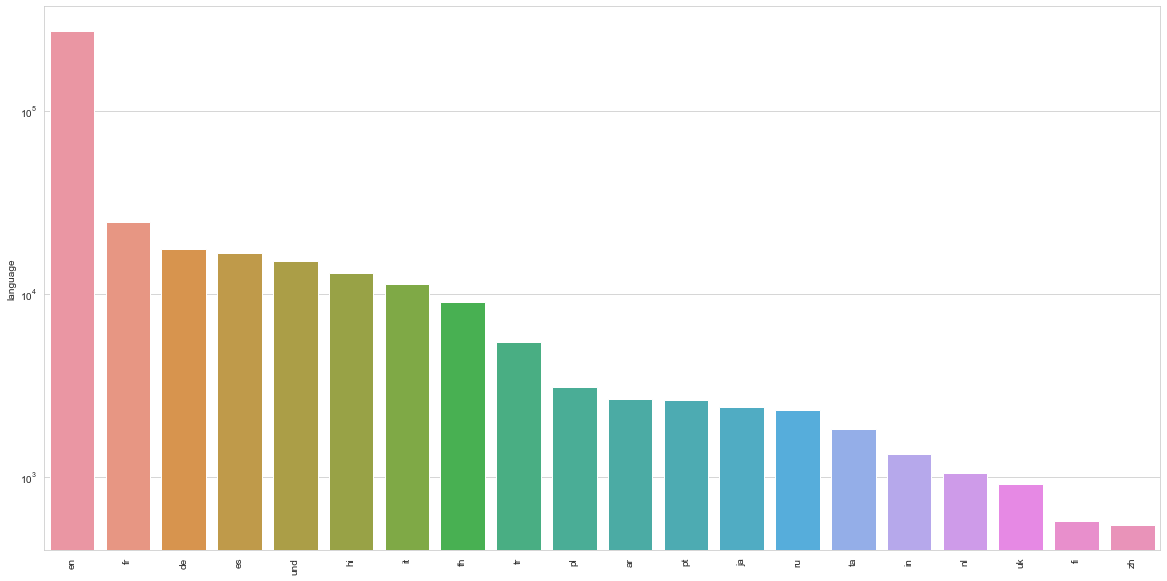

In [24]:
plt.figure(figsize=(20, 10))
sns.barplot(x=all_tweets['language'].value_counts()[:n_first].index, y=all_tweets['language'].value_counts()[:n_first])
plt.xticks(rotation=90)
plt.yscale("log")
plt.show()

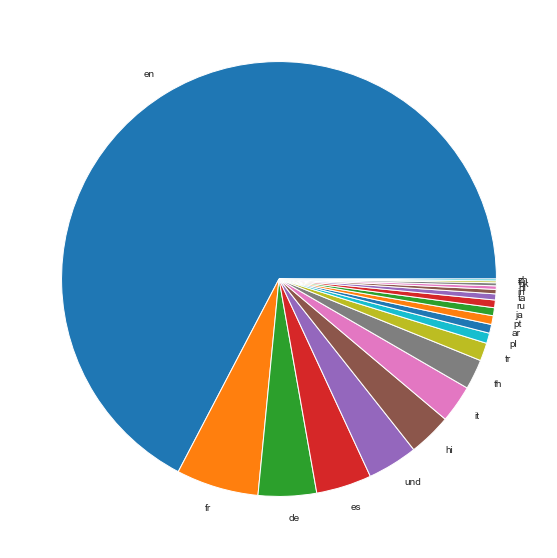

In [25]:
plt.figure(figsize=(20, 10))
plt.pie(x=all_tweets['language'].value_counts()[:n_first], labels=all_tweets['language'].value_counts()[:n_first].index)
plt.show()

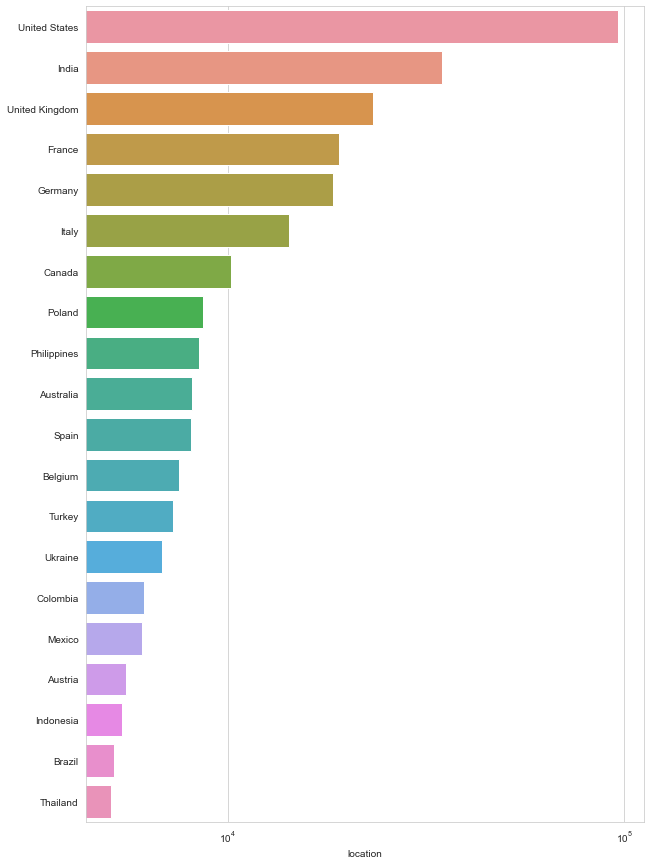

In [26]:
plt.figure(figsize=(10, 15))
sns.barplot(y=all_tweets['location'].value_counts()[:n_first].index, x=all_tweets['location'].value_counts()[:n_first])
plt.xscale("log")
plt.show()

In [27]:
all_tweets["tweetcreatedts"] = pd.to_datetime(all_tweets["tweetcreatedts"])
print(all_tweets["tweetcreatedts"])

userid
434693384    2022-03-02 00:00:00
2123763712   2022-03-02 00:00:00
152930351    2022-03-02 00:00:00
1024897024   2022-03-02 00:00:00
2343754771   2022-03-02 00:00:00
                     ...        
4252358719   2022-03-01 23:35:07
2891390985   2022-03-01 23:35:08
284707359    2022-03-01 23:35:08
352087687    2022-03-01 23:35:08
540463803    2022-03-01 23:35:08
Name: tweetcreatedts, Length: 414001, dtype: datetime64[ns]


Let's see 

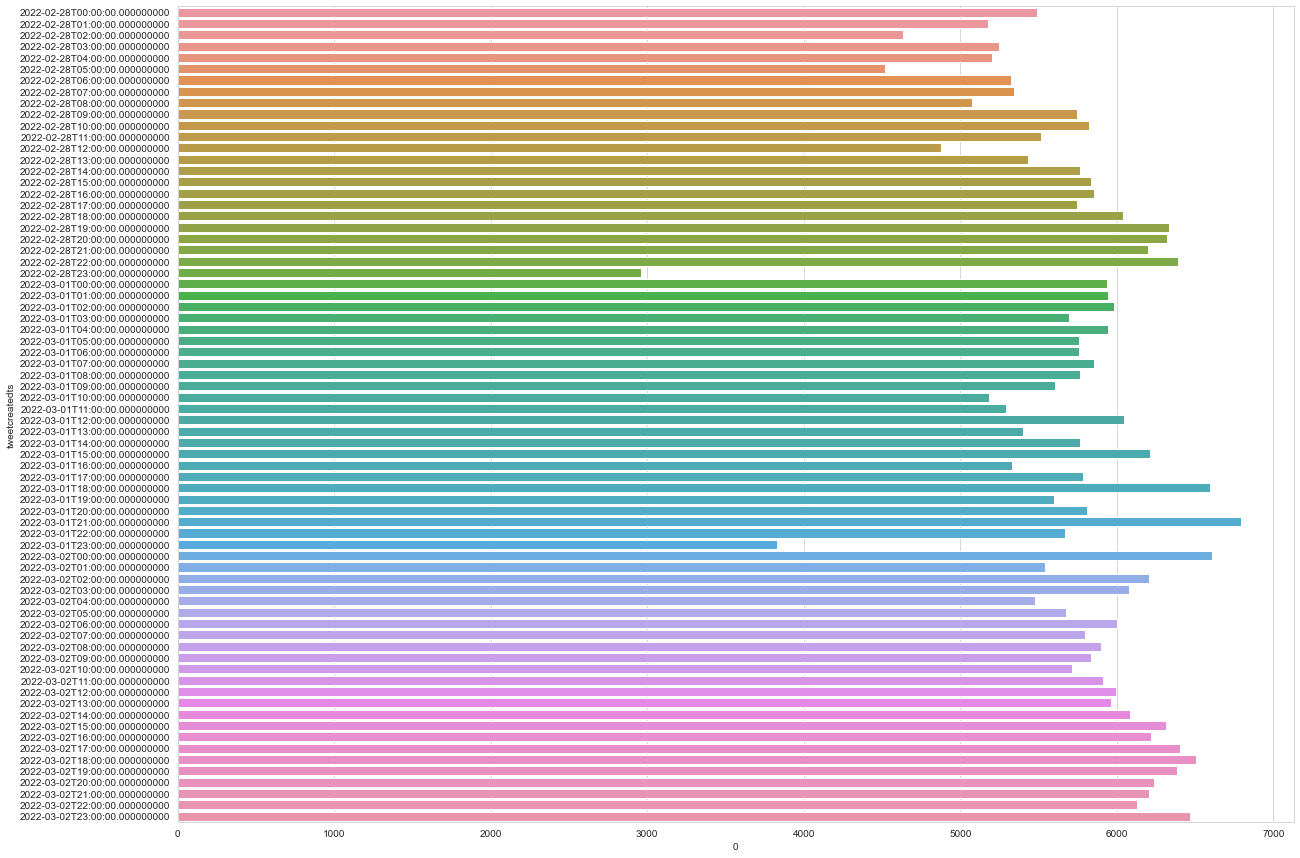

In [28]:
grouped_by_time = all_tweets[["tweetcreatedts", "text"]].groupby(pd.Grouper(key="tweetcreatedts",freq='H')).size().reset_index()

plt.figure(figsize=(20, 15))
sns.barplot(data=grouped_by_time, y="tweetcreatedts", x=0)
plt.show()

Study the anomaly peak on plot between 09:00:00 UTC the 1st of March and the 04:00:00 UTC the 2nd of March.

In [29]:
# TODO. implement study

## Curator advices:
- [ ] Consider 2 sides of the conflict - Ukraine and Russia (means analyze reactions from both sides):
    1. Consider reactions in Ukraine and Russia on all languages available
    2. Consider reactions in Ukraine and Russia on their native languages
    3. Build wordclouds for both states

- [ ] Look at countries-satellites reaction (both for Ukraine and Russia):
We choose only those countries who obviously supporting and giving MILITARY aid to Ukraine and Russia.
    1. Ukrainian satellites (#TODO: complete by [link](https://en.wikipedia.org/wiki/List_of_foreign_aid_to_Ukraine_during_the_Russo-Ukrainian_War#Beer_for_Ukraine)):
        a)
    2. Russian satellites (#TODO: complete by [link](https://www.ssatripura.com/countries-supporting-ukraine-russia/)):
        a) Belarus
        b) Iran
        c) Syria
- [ ] Take into account that there are refugees, which can distort some data (for example, Ukrainian refugees in Poland are still Ukrainians, but can change their account information, because Twitter doesn't verify all user info)
    - Retrieve all tweets in ukrainian (and mb russian) language and with not Ukraine locations etc.
    - The same for Russian tweeters.
- [ ] Analyze reaction of people in G20 countries and other alliances.
    Alliances to take into account:
    - G20
    - NATO
    - Major non-NATO ally

### Extract Ukrainian and Russian tweets from dataset
As Ukrainians are bilinguals (detailed study [The History of Bilingualism in Ukraine and Its Role in the Present Day Political Crisis](https://www.cairn-int.info/article-E_CSP_017_0203--the-history-of-bilingualism-in-ukraine.htm)) we firstly extracted tweets by language and then separate it by tweeters locations.

In [ ]:
g20_dict: dict[str, list[str]] = {
    'g1': ['Australia', 'Canada', 'Saudi Arabia', 'United States'],
    'g2': ['India', 'Russian Federation', 'South Africa', 'Turkey'],
    'g3': ['Argentina', 'Brazil', 'Mexico'],
    'g4': ['France', 'Germany', 'Italy', 'United Kingdom']
}
g20_list: list[str] = [
    'Argentina', 'Australia', 'Brazil', 'Canada',
    'China', 'France', 'Germany', 'India',
    'Indonesia', 'Italy', 'South Korea', 'Japan',
    'Mexico', 'Russian Federation', 'Saudi Arabia', 'South Africa',
    'Turkey', 'the United Kingdom', 'United States', 'European Union'
]